<a href="https://colab.research.google.com/github/RiverCho/AnalysingData_A3/blob/main/Assignment3_AD_S5735726.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3: LDA Topic Modeling

## Note
Installing Tomotopy locally can return an error, if that's the case run this notebook on Google Colab

## Research Background

LDA is a popular topic modeling algorithm widely used in the fields of Digital Humanities and Social Sciences. In the field of political communication, topic modeling is often applied for analyzing politicians Twitter/X posts, identitying thematic patterns or topics revolving around their posts.

For this assignment, students will work with tweets from two USA politicians, Donald Trump and Bernie Sanders, who are often regarded as right-wing populist and left-wing populist respectively. Right-wing populism often emphasizes nationalism, anti-immigration policies, and a critique of global elites from a culturally conservative perspective, focusing on preserving traditional values and social hierarchies. Left-wing populism prioritizes economic inequality, advocating for the redistribution of wealth, expansion of social services, and empowerment of the working class against the capitalist elite. While both forms of populism appeal to the "common people" against perceived elites and established structures, they diverge significantly in their identification of the elites, proposed solutions, and core ideologies. For a more detailed explanation, you can read the chapter by Macaulay (2019) "Bernie and The Donald: A comparison of left-and right-wing populist discourse" (full reference below).

**Research Questions**
1. What topics are revolving around Donald Trump and Bernie Sanders' posts separately?
2. What are the topic differences between Trump (right-wing popoulist) and Sanders (left-wing populist)?

**Aim:**
1. The first aim of the assignment is to conduct LDA topic modeling. Identify thematic patterns or politics revolving around Trump or Sanders's posts.
2. The second aim is to critically evaluate the results of topic modeling. Try different numbers of topics to see with which settings the topics are more coherent. Critically reflect on the results of LDA topic modeling, discussing them in relation to existing theories about populism.

**Data**
Two datasets are prepared for this assginment. Tweets from Trump and tweets from Sanders. Students are asked to work on these two datasets.

**Methods**
1. Word segamentation
2. Removing stopwords
3. LDA topic modeling
4. Topic evaulation (coherence and human evaluation)
5. Visualization of results.

**References**
1. Macaulay, M. (2019). Bernie and the Donald: A comparison of Left-and Right-wing populist discourse. *Populist discourse: International perspectives*, 165-195.





## Setup

### Q1. Install necessary libraries, including `tomotopy` and `little_mallet_wrapper`, and import them

In [4]:
# Q1 (code)
!pip install tomotopy
!pip install little_mallet_wrapper

In [83]:
import tomotopy as tp
import little_mallet_wrapper
import pandas as pd
import re
import nltk

## Data preprocessing

### Q2. Load the two datasets and concatenate them

The goal is to run topic modelling on the combined dataset of Sanders and Trump's tweets

In [84]:
# Q2 (code)

# Load Sanders tweets dataset
sanders_tweets_df = pd.read_csv("sanders_tweets.csv")

# Load Trump tweets dataset
trump_tweets_df = pd.read_csv("trump_tweets.csv")

# Concatenate the two datasets
tweets_df = pd.concat([sanders_tweets_df, trump_tweets_df], ignore_index=True)

# Display the first few rows of the combined dataset to verify concatenation
print(tweets_df.head())

     Username              TweetId                           Title  \
0  SenSanders  1351670845639421952  SenSanders_1351670845639421952   
1  SenSanders  1351259762722279424  SenSanders_1351259762722279424   
2  SenSanders  1351242822293319680  SenSanders_1351242822293319680   
3  SenSanders  1350885541911400448  SenSanders_1350885541911400448   
4  SenSanders  1349880150041780224  SenSanders_1349880150041780224   

                                             Content  
0  Wealth increase in past 10 months:\n⬆️$173 bil...  
1  Amidst massive income and wealth inequality te...  
2  “We now have the resources, we now have the sk...  
3  After surviving an attempt on his life, Russia...  
4  President-Elect Biden's COVID rescue plan will...  


### Q3. Clean the data

Transform all tweets to lowercase, remove stopwords, punctuation, and numbers. Add the processed text to a list called `training_data`.
Create a list with the content of the tweets (`original_texts`) and a list that allows you to identify both the author of the tweet and its ID (`titles`).


In [85]:
# Q3 (code)

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download necessary NLTK resources
nltk.download("words")
nltk.download("punkt")
nltk.download("stopwords")

# Initialize NLTK's stopwords
stop_words = set(stopwords.words("english"))

# Define functions for text preprocessing
def clean_emoji(text):
    return text.encode("ascii", "ignore").decode("ascii")

# Regular expressions for text patterns to be removed
reg_map = [
    # Matches retweet indicators (e.g., "rt@username:"), URLs, hashtags, and specific Twitter handles
    re.compile(r"rt[@0-9a-z_]{0,10}:|http\S+|www\S+|https\S+|\/\/t|co\/|realdonaldtrump|#\w+|amp+|rt"),
]

def lower_and_remove_with_reg(text):
    text = text.lower()
    # Remove patterns including URLs, user mentions, and Twitter-specific patterns
    for pattern in reg_map:
        text = pattern.sub("", text)
    # Remove numeric characters
    text = re.sub(r'\d+', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    return text

def tokenize_and_remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words and len(word) >= 2]
    return filtered_tokens

# Create lists for storing processed data
training_data = []
original_texts = []
titles = []

# Iterate through each tweet in the dataset
for index, row in tweets_df.iterrows():
    original_text = row['Content']
    author = row['Username']
    tweet_id = row['TweetId']

    # Clean the text
    processed_text = lower_and_remove_with_reg(original_text)
    processed_text = clean_emoji(processed_text)
    processed_text = " ".join(tokenize_and_remove_stopwords(processed_text))

    # Append processed text to training_data
    training_data.append(processed_text)

    # Append original text to original_texts
    original_texts.append(original_text)

    # Create title for the tweet (author + tweet_id) and append to titles
    title = f"{author}_ID{tweet_id}"
    titles.append(title)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## LDA topic modelling

### Q4. Train a an LDA topic model with `tomotopy`

In [65]:
# Q4 (code)

# Define the number of topics
num_topics = 15

# Create an LDA model
lda_model = tp.LDAModel(k=num_topics)

# Add the preprocessed data to the model
for text in training_data:
    lda_model.add_doc(text.split())

# Train the model
lda_model.train(0)  # Initialize training

# Train for the specified number of iterations
print("Topic Model Training...\n\n")
num_iters = 10
for i in range(num_iters):
    lda_model.train(1)
    print('Iteration: {:d} LL per word: {:.3f}'.format(i, lda_model.ll_per_word))

Topic Model Training...


Iteration: 0 LL per word: -10.771
Iteration: 1 LL per word: -10.274
Iteration: 2 LL per word: -10.027
Iteration: 3 LL per word: -9.884
Iteration: 4 LL per word: -9.784
Iteration: 5 LL per word: -9.701
Iteration: 6 LL per word: -9.623
Iteration: 7 LL per word: -9.552
Iteration: 8 LL per word: -9.484
Iteration: 9 LL per word: -9.413


### Q5. Print out the top words for each topic and manually evaluate their coherence


In [66]:
# Q5a (code)
# Get the top words for each topic
num_topic_words = 15

print("\nTopic Model Results:\n")
topics = []
topic_individual_words = []
for topic_id in range(0, num_topics):
    topic_words = ' '.join(word for word, prob in lda_model.get_topic_words(topic_id=topic_id, top_n=num_topic_words))
    topics.append(topic_words)
    topic_individual_words.append(topic_words.split())
    print(f"Topic {topic_id}: {topic_words}\n")


Topic Model Results:

Topic 0: people border fake news democrats security must dont want us media country american president many

Topic 1: president great whitehouse today trump news new thank house media caign job fake white live

Topic 2: trump president fbi cou witch like news hunt mueller democrats collusion would people russia clinton

Topic 3: people must country american wage workers us need pay health states war time americans care

Topic 4: president great trump people democrats us foxnews pm tonight house impeachment want must enjoy election

Topic 5: must people america us need health country make great care thank pay working families work

Topic 6: great trump president joe biden democrats military people total endorsement would job new border vote

Topic 7: great people president american many us china big america country much states jobs would united

Topic 8: people would drug biden joe us great prices trump president big get never democrats china

Topic 9: president n

Q5b (words)

Describe what each topic is about. What ideas, values, or situations do these keywords refer to?

1. Topic 0: This topic appears to be related to Trump's presidency, with keywords such as "trump," "president," "russia," "collusion," and "mueller." It suggests discussions about investigations, news coverage, and political controversies surrounding Trump.

2. Topic 1: This topic seems to focus on Trump's leadership and his relationship with the American people. Keywords like "great," "president," "trump," "american," and "china" indicate discussions about Trump's policies, popularity, and international relations.

3. Topic 2: This topic revolves around domestic policies, particularly taxation and employment. Keywords such as "tax," "people," "american," "workers," and "security" suggest discussions about tax reforms, employment issues, and national security.

4. Topic 3: Similar to Topic 2, this topic also involves discussions about Trump, Democrats, and domestic policies. It emphasizes the role of Democrats and their impact on various aspects of American life.

5. Topic 4: This topic appears to focus on voting, border security, and political parties. Keywords like "vote," "border," "president," "democrats," and "republican" suggest discussions about elections, immigration policies, and party politics.

6. Topic 5: This topic seems to involve discussions related to political controversies, particularly those involving Democrats and elections. Keywords such as "would," "democrats," "impeachment," "biden," and "election" indicate discussions about impeachment proceedings, election campaigns, and political strategies.

7. Topic 6: This topic focuses on Trump's leadership and policies, with keywords like "great," "new," "president," "trump," and "america." It suggests discussions about Trump's achievements, initiatives, and public appearances.

8. Topic 7: Similar to Topic 6, this topic also revolves around Trump's presidency and media coverage. It includes keywords like "great," "news," "trump," "fake," and "media," indicating discussions about news reporting, media bias, and public perceptions of Trump.

9. Topic 8: This topic involves discussions about the presidency, the White House, and political dynamics. It includes keywords like "president," "whitehouse," "thank," "trump," and "democrats," suggesting discussions about presidential activities, gratitude, and political opposition.

10. Topic 9: This topic appears to focus on endorsements, healthcare, and the military. Keywords like "great," "military," "healthcare," "complete," and "president" suggest discussions about military endorsements, healthcare reforms, and presidential leadership.

11. Topic 10: This topic revolves around news media, particularly discussions about fake news and media coverage of Trump. It includes keywords like "news," "fake," "trump," "media," and "democrats," indicating discussions about media credibility, bias, and Trump's relationship with the press.

12. Topic 11: This topic involves discussions about national identity, elections, and public opinion. Keywords like "people," "great," "country," "election," and "would" suggest discussions about national pride, election outcomes, and public sentiment.

13. Topic 12: This topic seems to focus on domestic issues such as healthcare, employment, and trade. It includes keywords like "people," "us," "health," "jobs," and "trade," indicating discussions about domestic policies and their impact on the American people.

14. Topic 13: This topic revolves around healthcare policies and public health. Keywords like "health," "care," "country," "system," and "trump" suggest discussions about healthcare reforms, public health initiatives, and Trump's healthcare agenda.

15. Topic 14: This topic appears to focus on national security, particularly discussions about border security and voting. Keywords like "great," "trump," "people," "wall," and "security" suggest discussions about border wall construction, national security measures, and immigration policies.

## Topic coherence

Use `tomotopy`'s [`.coherence()`](https://bab2min.github.io/tomotopy/v0.10.0/en/coherence.html) function to automatically calculate the topic coherence.

The coherence value can vary from `0` (no coherence) to `1` (maximum coherence). Interpret the results and, if needed, retrain the model using a different number of topics.

In [11]:
# There are different metrics for coherence, we choose `c_v`

coh = tp.coherence.Coherence(lda_model, coherence='c_v')
average_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(lda_model.k)]

print('==== Coherence : {} ===='.format('c_v'))
print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
print()

==== Coherence : c_v ====
Average: 0.4384778102238973 
Per Topic: [0.3916928078979254, 0.3629727065563202, 0.417431878298521, 0.344229981303215, 0.3969643861055374, 0.6101435422897339, 0.4845062017440796, 0.4938622549176216, 0.3537726651877165, 0.7449850469827652, 0.3261994581669569, 0.3786512061953545, 0.4914327565580606, 0.4406248465180397, 0.33969741463661196]



In [85]:
# Initialize lists to store coherence scores
coherence_scores = []
coherence_scores_per_topic = []

# Iterate over different number of topics (from 15 to 50, incrementing by 5)
for num_topics in range(10, 51, 5):
    # Create a new LDA model with the specified number of topics
    new_lda_model = tp.LDAModel(k=num_topics)

    # Add the preprocessed data to the new model
    for text in training_data:
        new_lda_model.add_doc(text.split())

    # Train the new model
    new_lda_model.train(0)  # Initialize training

    # Train for the specified number of iterations
    num_iters = 10
    for i in range(num_iters):
        new_lda_model.train(1)

    # Calculate coherence score for the new model
    coh = tp.coherence.Coherence(new_lda_model, coherence='c_v')
    average_coherence = coh.get_score()
    coherence_per_topic = [coh.get_score(topic_id=k) for k in range(new_lda_model.k)]

    # Append the coherence scores to the lists
    coherence_scores.append(average_coherence)
    coherence_scores_per_topic.append(coherence_per_topic)

    # Print coherence scores
    print('==== Coherence for {} Topics : c_v ===='.format(num_topics))
    print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
    print()

==== Coherence for 10 Topics : c_v ====
Average: 0.3841667313035578 
Per Topic: [0.4309768619947135, 0.3096058316528797, 0.3749477509409189, 0.29841827526688575, 0.48176316618919374, 0.3127262398600578, 0.47803654968738557, 0.3396053671836853, 0.40757612884044647, 0.4080111414194107]

==== Coherence for 15 Topics : c_v ====
Average: 0.44258919154604287 
Per Topic: [0.4768621638417244, 0.5018703736364841, 0.4731284542009234, 0.3832896500825882, 0.399984247982502, 0.4420154899358749, 0.40392365902662275, 0.3730669170618057, 0.37056697607040406, 0.3324249602854252, 0.3521899335086346, 0.653059121966362, 0.5439526394009591, 0.4305648969486356, 0.5019383892416954]

==== Coherence for 20 Topics : c_v ====
Average: 0.45812381115742024 
Per Topic: [0.4347204312682152, 0.44868682622909545, 0.45342623963952067, 0.33580854143947364, 0.4607318088412285, 0.6645331501960754, 0.396847603097558, 0.5995390120893717, 0.3973525270819664, 0.3384085804224014, 0.5417872130870819, 0.5777351751923561, 0.57655

### Q6. Interpret topic coherence

Report the following:
- number of topics you initially used to train the model and the coherence score you got
- changes made to the number of topics and new coherence scores obtained

Q6 (words)

According to the coherence scores:

- Initially, the model was trained with 15 topics, and the average coherence score obtained was 0.426.
- As the number of topics increases, the average coherence score generally shows an upward trend, rising from 0.384 with 10 topics to 0.528 with 50 topics，indicating that increasing the number of topics can improve the model's coherence.
- The peak average coherence scores are reached between 30 and 40 topics, exceeding 0.5, and remain relatively high at 50 topics. At higher numbers of topics (50 to 60 topics), the coherence scores show a slight decline but still remain at relatively high levels.

However, an increase in coherence scores does not necessarily mean an improvement in model performance, as an excessive number of topics may lead to increased model complexity, thereby reducing its effectiveness in practical applications. Therefore, based on these results, it can be inferred that models with 40 topics may have the best coherence and performance.

### X1. Optional question 1
(This question is not compulsory, it only allows you to get an extra point.)

Create a function to plot the average coherence for models with different number of topics.

==== Coherence for 10 Topics : c_v ====
Average: 0.36274964406155047 
Per Topic: [0.33999616606161, 0.317412893474102, 0.30770387798547744, 0.31459809839725494, 0.47173972353339194, 0.3683899104595184, 0.3647240616381168, 0.3844266042113304, 0.35252612829208374, 0.4059789765626192]

==== Coherence for 15 Topics : c_v ====
Average: 0.4157108593406156 
Per Topic: [0.30176652520895003, 0.42400408145040275, 0.39990160018205645, 0.30751603916287423, 0.5218189382227137, 0.3672076627612114, 0.520987968891859, 0.43064290955662726, 0.4352818201761693, 0.4220043733716011, 0.6146608680486679, 0.35292427241802216, 0.30725382566452025, 0.4177449855953455, 0.41194701939821243]

==== Coherence for 20 Topics : c_v ====
Average: 0.44446007322520026 
Per Topic: [0.41814974322915077, 0.4436430215835571, 0.37188139408826826, 0.4335023283958435, 0.4071395844221115, 0.5309369415044785, 0.43423607796430586, 0.5073099285364151, 0.6581091180443763, 0.4950415402650833, 0.38201053291559217, 0.43905177116394045, 

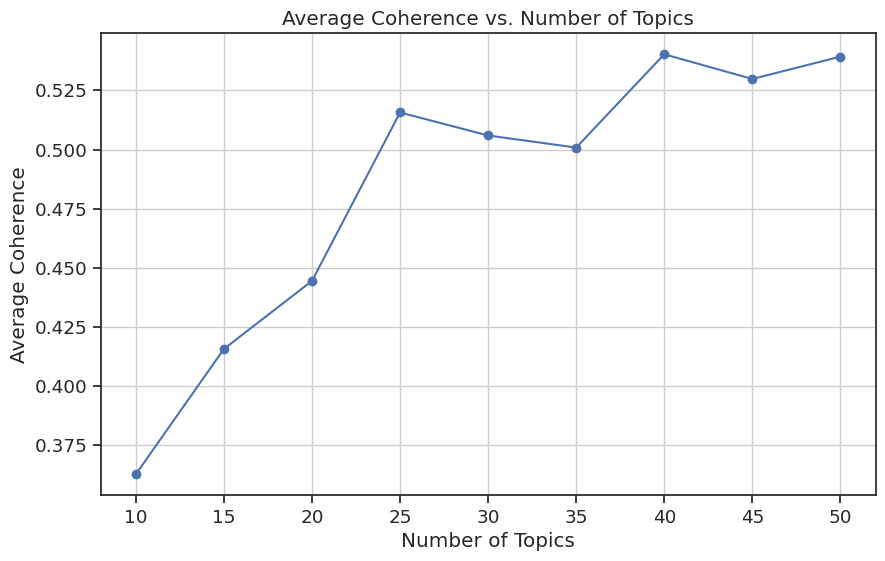

In [88]:
# X1 (code)
# Tip: y = average topic coherence; x = number of topics in the model

import matplotlib.pyplot as plt

def plot_coherence(num_topics_range, coherence_scores):
    plt.figure(figsize=(10, 6))
    plt.plot(num_topics_range, coherence_scores, marker='o', linestyle='-')
    plt.title('Average Coherence vs. Number of Topics')
    plt.xlabel('Number of Topics')
    plt.ylabel('Average Coherence')
    plt.grid(True)
    plt.show()

# Initialize lists to store coherence scores
coherence_scores = []
coherence_scores_per_topic = []
num_topics_range = range(10, 51, 5)  # Adjusted the range to start from 10

# Iterate over different number of topics (from 10 to 50, incrementing by 5)
for num_topics in num_topics_range:
    # Create a new LDA model with the specified number of topics
    new_lda_model = tp.LDAModel(k=num_topics)

    # Add the preprocessed data to the new model
    for text in training_data:
        new_lda_model.add_doc(text.split())

    # Train the new model
    new_lda_model.train(0)  # Initialize training

    # Train for the specified number of iterations
    num_iters = 10
    for i in range(num_iters):
        new_lda_model.train(1)

    # Calculate coherence score for the new model
    coh = tp.coherence.Coherence(new_lda_model, coherence='c_v')
    average_coherence = coh.get_score()
    coherence_per_topic = [coh.get_score(topic_id=k) for k in range(new_lda_model.k)]

    # Append the coherence scores to the lists
    coherence_scores.append(average_coherence)
    coherence_scores_per_topic.append(coherence_per_topic)

    # Print coherence scores
    print('==== Coherence for {} Topics : c_v ===='.format(num_topics))
    print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
    print()

# Call the function to plot the coherence scores
plot_coherence(num_topics_range, coherence_scores)

### Q7. Topic distributions
Calculate the topic distributions for all tweets and get the top documents for some topics (between 2 and 5) that you think could be more representative of Sanders or Trump.

In [82]:
# Q7a (code)

from IPython.display import Markdown, display

topic_distributions = [list(doc.get_topic_dist()) for doc in lda_model.docs]

def make_md(string):
    display(Markdown(str(string)))

def get_top_docs(text, topic_distributions, topic_indices, n=5):
    # Iterate over the selected topic indices
    for topic_index in topic_indices:
        # Sort documents based on their probability for the current topic
        sorted_data = sorted([(dist[topic_index], doc) for dist, doc in zip(topic_distributions, text)], reverse=True)

        # Get the words associated with the current topic
        topic_words = topics[topic_index]

        # Display topic words and related documents
        make_md(f"### Topic {topic_index}\n\n{topic_words}\n\n")
        print("---")

        # Display top n documents for the current topic
        for probability, doc in sorted_data[:n]:
            # Highlight topic words in the document
            for word in topic_words.split():
                if word in doc.lower():
                    doc = re.sub(f"\\b{word}\\b", f"**{word}**", doc, re.IGNORECASE)

            # Display the document with its associated probability
            make_md(f'\n**Topic Probability**: {probability}  \n**Document**: {doc}\n\n')

print("\nTop documents for topics potentially related to Sanders:\n")
get_top_docs(original_texts, topic_distributions, topic_indices=[2, 13])

print("\nTop documents for topics potentially related to Trump:\n")
get_top_docs(original_texts, topic_distributions, topic_indices=[1, 6, 9])


Top documents for topics potentially related to Sanders:



### Topic 2

trump president fbi cou witch like news hunt mueller democrats collusion would people russia clinton



---



**Topic Probability**: 0.9065974950790405  
**Document**:  The Democrats know that they are creating havoc on Election night. This is what they want. WE WILL WIN! https://t.co/BkPYHwsRTr




**Topic Probability**: 0.9065974950790405  
**Document**:  RT @kevinomccarthy: A great nation because of great **people**. I’m proud to stand with @realdonaldtrump and to work for YOU. #RNC2020 🇺🇸 https://t.co/eeclyiCo1N




**Topic Probability**: 0.8776121139526367  
**Document**: A vote for ‘skinny repeal’ is a vote to take health insurance from 16 million and drastically increase premiums for everyone else.




**Topic Probability**: 0.853499710559845  
**Document**:  RT @WhiteHouse: Our great American workers are winning under President @realDonaldTrump! 🇺🇸 https://t.co/SDIYGwLNId




**Topic Probability**: 0.8371932506561279  
**Document**: Rather than the **president** issuing misguided executive orders, we must pass comprehensive, humane immigration reform.
https://t.co/2rBiG9DulN



### Topic 13

people trump president thank americans great must time get going every states american america house



---



**Topic Probability**: 0.9021216630935669  
**Document**:  https://t.co/BUfd3JWxy4




**Topic Probability**: 0.9021216630935669  
**Document**:  RT @WhiteHouse: Nineteen years ago, 40 brave men and women triumphed over terror and gave their lives in defense of our Nation.  We are forever in their debt. https://t.co/BUZzQjt7iZ




**Topic Probability**: 0.8715589046478271  
**Document**:  RT @thebradfordfile: WOW. President Trump's support among black voters rose 9 points during the GOP convention.




**Topic Probability**: 0.8697372674942017  
**Document**: “The **president** cannot erase the Constitution with an executive order... This is a transparent and blatantly unconstitutional attempt to sow division and fan the flames of anti-immigrant hatred in the days ahead of the midterms.” —@OmarJadwat, ACLU’s Immigrants’ Rights Project




**Topic Probability**: 0.8697372674942017  
**Document**: The United States needs to move toward community policing and make our police departments look more like the communities they serve.




Top documents for topics potentially related to Trump:



### Topic 1

president great whitehouse today trump news new thank house media caign job fake white live



---



**Topic Probability**: 0.8912003040313721  
**Document**:  For the record, there were MANY people who wanted to be the White House Chief of Staff. Mick M will do a GREAT **job**!




**Topic Probability**: 0.8862369656562805  
**Document**:  Gina Haspel did a spectacular **job** **today**. There is nobody even close to run the CIA!




**Topic Probability**: 0.8848421573638916  
**Document**:  RT @GOPChairwoman: The #DemDebate was emblematic of the Democrats' week: a total disaster, short on ideas to actually help Americans.  @realDonaldTrump had one of the best of his presidency: huge turnout in Iowa, strong SOTU, acquittal and a fantastic jobs report.  Trump is the best choice in 2020!




**Topic Probability**: 0.8776947855949402  
**Document**:  Congratulations to a truly **great** football team, the Clemson Tigers, on an incredible win last night against a powerful Alabama team. A big win also for the Great State of South Carolina. Look forward to seeing the team, and their brilliant coach, for the second time at the W.H.




**Topic Probability**: 0.8768007159233093  
**Document**:  John Kasich did a bad **job** in Ohio, ran for President and was easy to beat, and now went to the other side desperate for relevance. Good Job by Chris C in exposing yet another loser! https://t.co/WZw2U7lcrf



### Topic 6

great trump president joe biden democrats military people total endorsement would job new border vote



---



**Topic Probability**: 0.9107896685600281  
**Document**:  Some states use “drop boxes” for the collection of Universal Mail-In Ballots. So who is going to “collect” the Ballots, and what might be done to them prior to tabulation? A Rigged Election? So bad for our Country. Only Absentee Ballots acceptable!




**Topic Probability**: 0.8910877108573914  
**Document**:  The Witch Hunt continues! https://t.co/pBzhZfJEYb




**Topic Probability**: 0.8816255331039429  
**Document**:  RT @charliekirk11: Facts:  California’s Motor Voter law resulted in AT LEAST 1,500 **people**, including non-citizens, being registered to **vote**  California’s Secretary of State just admitted that multiple **people** voted multiple times last election  Voter fraud is real  America needs voter ID NOW!  RT!




**Topic Probability**: 0.877568244934082  
**Document**:  Mini Mike Bloomberg, after making a **total** fool of himself as he got badly beaten up by Pocahontas and the Democrats in the Primaries, is at it again. He tried to buy an Election and went away with a major case of Depression. Now he’s throwing money at the Dems, looking for a **job**!




**Topic Probability**: 0.8655652403831482  
**Document**:  “COVID-19 (China Virus) Death Rate PLUNGES From Peak In U.S.” A Tenfold Decrease In Mortality. The Washington Times @WashTimes  Valerie Richardson.  We have the lowest Mortality Rate in the World. The Fake News should be reporting these most important of facts, but they don’t!



### Topic 9

president news trump democrats fake election people country even years would nothing united media states



---



**Topic Probability**: 0.8911210894584656  
**Document**:  No. A Rigged Election! https://t.co/2Bizcisgco




**Topic Probability**: 0.8911210894584656  
**Document**:  Fake News! https://t.co/pL9gMFvZEn




**Topic Probability**: 0.8655925989151001  
**Document**:  https://t.co/H2FiSVxyOF




**Topic Probability**: 0.8602595925331116  
**Document**:  Had a very good call last night with the President of China concerning the menace of North Korea.




**Topic Probability**: 0.8522266745567322  
**Document**: Trump gave the top 1% and large corporations $1 trillion in tax breaks.  Now, he wants to repeal the Estate Tax and make his billionaire friends **even** richer. Wrong! At a time of massive wealth inequality, the very rich must pay their fair share of taxes.



Interpret the results above. Are there topics that have top tweets only by one politician? Why do you think these topics are more representative of one of the two politicians' views?

Q7b (words)
### Top documents for topics potentially related to Sanders:

Topic 2:
- **Representative Tweets**: Involves taxation, economic fairness, and workers' rights. Emphasize taxing the wealthy and corporations to support the working class.
- **Associated Politician**: More aligned with Bernie Sanders' policies and stance.

This topic aligns more with Sanders' political ideology, as he has consistently emphasized taxing the wealthy and corporations to support the working class. Therefore, the top tweets in this topic are likely to be posted solely by Sanders.

Topic 13:
- **Representative Tweets**:Involves healthcare system and the health of the people. Likely to focus on healthcare policies and the well-being of Americans.
- **Associated Politician**: Possibly relevant to both politicians, but more closely aligned with Bernie Sanders' policies.

This topic is relevant to both politicians as they both have expressed opinions on healthcare reform. However, it aligns more with Bernie Sanders' views as he emphasizes universal healthcare. Therefore, the top tweets in this topic are likely to be posted solely by Sanders.

### Top documents for topics potentially related to Trump:

Topic 1:
- **Representative Tweets**: Involves international affairs, leadership, and views on China. More likely to emphasize international leadership and stance towards China.
- **Associated Politician**: More aligned with Donald Trump's policies and stance.

Trump frequently discusses international affairs and his views on China on social media. Therefore, the top tweets in this topic are likely to be posted solely by Trump.

Topic 6:
- **Representative Tweets**: Involves economic growth, job creation, and energy policies. Likely to emphasize economic achievements, job opportunities, and energy development.
- **Associated Politician**: More aligned with Donald Trump's policies and stance.

This topic is more relevant to Trump's policy priorities, as he often highlights economic growth and job creation on social media. Therefore, the top tweets in this topic are likely to be posted solely by Trump.

Topic 9:
- **Representative Tweets**: Involves military, national security, and trade issues. Likely to involve topics such as defense spending, trade agreements, and military actions.
- **Associated Politician**: More aligned with Donald Trump's policies and stance.

This topic is more relevant to Trump's policy priorities, as he has consistently emphasized national security and military strength. Therefore, the top tweets in this topic are likely to be posted solely by Trump.


In summary, some topics may have top tweets posted only by one politician, which may be because these topics are more closely aligned with that politician's policy priorities and stance. For instance, topics related to economic fairness and workers' rights are more representative of Bernie Sanders' views, while topics related to national security and international affairs are more representative of Donald Trump's views.

## Large scale analysis

### Q8. Create a random sample of the whole dataset and visualize the topic distributions for the sampled tweets

In [67]:
# Crete a sample of tweets

from random import sample

target_labels = sample(titles,100)

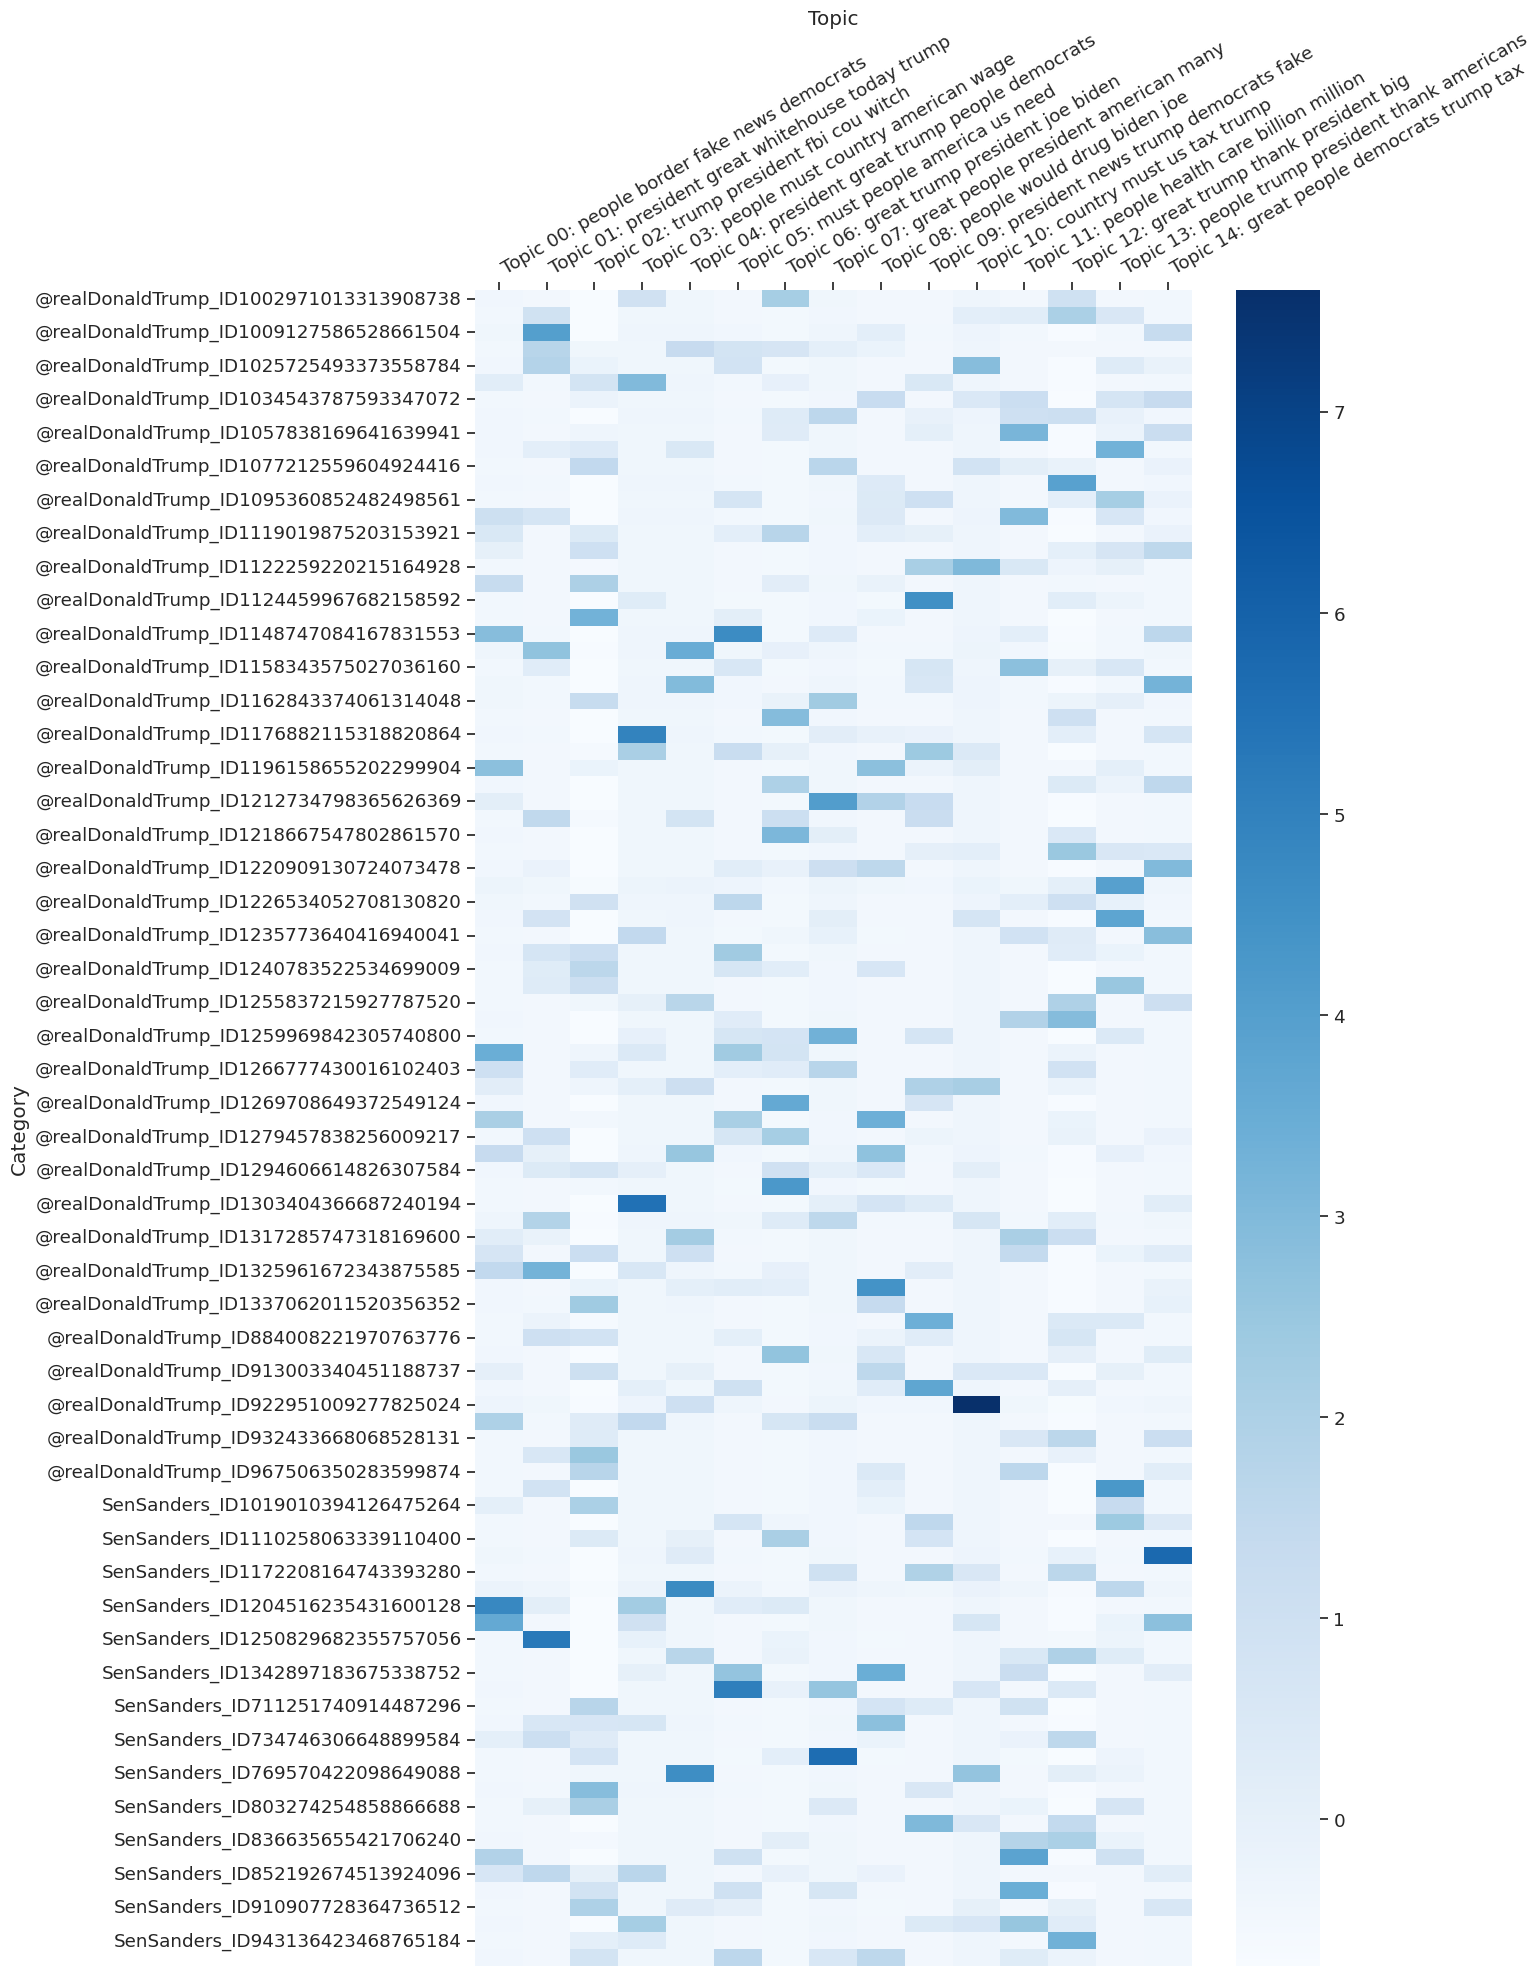

In [76]:
# Q8 (code)
# Create a heatmap using the random sample
# Tip: to display more than 20 tweets you have to change the values of `dim =` in sns.heatmap()

import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style and font scale
sns.set(style='ticks', font_scale=1.2)

def plot_categories_by_topics_heatmap(target_labels,
                                      topic_distributions,
                                      topic_keys,
                                      color_map=sns.cm.rocket_r):

 # Prepare data for heatmap
    dicts_to_plot = []
    for _label, _distribution in zip(target_labels, topic_distributions):
        for _topic_index, _probability in enumerate(_distribution):
            dicts_to_plot.append({'Probability': float(_probability),
                                  'Category': _label,
                                  'Topic': 'Topic ' + str(_topic_index).zfill(2) + ': ' + ' '.join(topic_keys[_topic_index][:5])})

    df_to_plot = pd.DataFrame(dicts_to_plot)
    df_wide = df_to_plot.pivot_table(index='Category',
                                     columns='Topic',
                                     values='Probability')

    # Normalize the columns of the dataframe
    df_norm_col = (df_wide - df_wide.mean()) / df_wide.std()

    # Plot heatmap
    plt.figure(figsize=(15, 20))
    ax = sns.heatmap(df_norm_col, cmap=color_map)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    plt.xticks(rotation=30, ha='left')
    plt.tight_layout()
    plt.show()

plot_categories_by_topics_heatmap(target_labels,
                                  topic_distributions,
                                  topic_individual_words,
                                  color_map='Blues')

### Q9. Interpret the heatmap
Do you see any pattern in the probability distributions of topics for each politician?

Are there topics that are more likely for one of the two politicians?

In a heatmap, if a particular topic has darker colors, it indicates a higher probability of tweets on that topic. From the above analysis, we can analyze the distribution of tweets by Trump and Sanders on different topics:

**Trump's Tweets:**
- Topic 3: Tweets about "people must pay wages, healthcare, and national health for the United States" appear darker in the heatmap, indicating Trump frequently discusses these topics, or they are related to his political stance or policy focus.
- Topic 6: Tweets about "President Trump, Joe Biden, Democrats, military, border, voting" appear darker in the heatmap, suggesting Trump frequently discusses these topics on Twitter and they may be one of his key topics on social media.
- Topic 9: Tweets about "presidential news, Trump, Democrats, fake elections, country, media, unity, even years" appear darker in the heatmap, indicating Trump frequently discusses political news, the Democratic Party, and election-related topics.
- Topic 10: Tweets about "country must, our taxes, Trump, America, people, world, American, fossil fuels, presidential energy, working together" appear darker in the heatmap, suggesting Trump is highly interested in topics related to national taxes, energy policies, etc.

**Sanders's Tweets:**
- Topic 0: Tweets about "people, border, fake news, Democrats, security, don't want, our media, country, America, president, many" appear darker in the heatmap, suggesting Sanders frequently discusses immigration policy, fake news, etc.
- Topic 1: Tweets about "president, great, White House, today, Trump, news, new, thank, White House, campaign, job, fake, white, live" appear darker in the heatmap, indicating Sanders frequently discusses topics related to the president and the White House.
- Topic 5: Tweets about "must, people, America, need, health, country, make, great, care, thank, pay, working, families, work" appear darker in the heatmap, suggesting Sanders is highly interested in healthcare and working families' issues.
- Topic 14: Tweets about "great, people, Democrats, Trump, tax, Republicans, thank, country, Americans, American, America, would, make, Republican" appear darker in the heatmap, suggesting Sanders is interested in topics related to the Democratic Party, tax policies, etc.

In summary, by observing darker-colored topics, we can understand the key topics and political positions that Trump and Sanders focus on Twitter.

### X2. Optional question 2
(This question is not compulsory, it only allows you to get an extra point)

Make the sample balanced, with 50 tweets by Trump and 50 by Sanders.

In [79]:
# X2 (code)

# Separate tweets into two lists based on authorship
trump_tweets = [tweet for tweet in titles if 'Trump' in tweet]
sanders_tweets = [tweet for tweet in titles if 'Sanders' in tweet]

# Sample 50 tweets from each category
trump_sample = sample(trump_tweets, 50)
sanders_sample = sample(sanders_tweets, 50)

# Combine the samples
balanced_sample = trump_sample + sanders_sample

### X3. Optional question 3
(This question is not compulsory, it only allows you to get an extra point)

Extend the analysis to all the tweets in the dataset.

        Topic_0   Topic_1   Topic_2   Topic_3   Topic_4   Topic_5   Topic_6  \
0     -0.496191 -0.502776 -0.069967 -0.500111 -0.495200 -0.498910  6.632200   
1     -0.483160 -0.489771 -0.493535 -0.147653 -0.482451  0.169272 -0.484729   
2      0.584420  0.036562 -0.471462 -0.463469  1.544946 -0.463147 -0.460976   
3     -0.486832  1.987758  0.331685 -0.490800 -0.486043  0.115508 -0.488394   
4     -0.488465 -0.495065 -0.498455  4.036613 -0.487641 -0.491408 -0.490023   
...         ...       ...       ...       ...       ...       ...       ...   
28991 -0.473626 -0.480255 -0.484693 -0.477662  5.146589 -0.084065 -0.475214   
28992 -0.442949 -0.449639 -0.456243  0.177039 -0.443113 -0.447213 -0.444598   
28993  2.871347 -0.480255 -0.484693 -0.477662 -0.473124 -0.476999 -0.475214   
28994 -0.476348 -0.099389 -0.487217 -0.480370 -0.475787 -0.479643 -0.477931   
28995  1.994986 -0.375466 -0.387318 -0.373209 -0.370407 -0.375049  3.061484   

        Topic_7   Topic_8   Topic_9  Topic_10  Topi

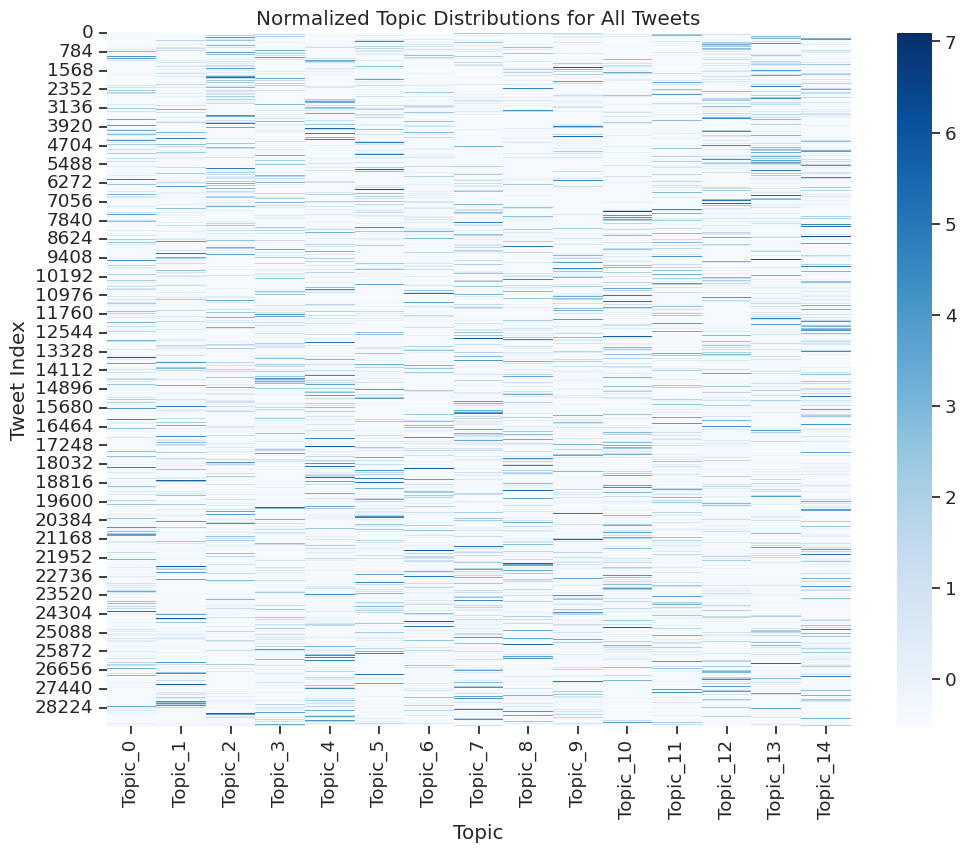

In [81]:
# X3 (code and words)
# Tip: plotting a heatmap for thousands of tweets is not practical.
# Make a comparison based on the numerical values in the `df_norm_col` dataframe (see Week 6 notebook)

# Create a DataFrame containing topic distributions for all tweets
df_to_plot = pd.DataFrame(topic_distributions, columns=[f'Topic_{i}' for i in range(len(topic_distributions[0]))])

# Calculate the mean and standard deviation of each topic across all tweets
topic_means = df_to_plot.mean()
topic_std = df_to_plot.std()

# Normalize the entire dataframe using the calculated mean and standard deviation
df_norm_all = (df_to_plot - topic_means) / topic_std

# Print the normalized dataframe
print(df_norm_all)

# Plotting a heatmap for comparison (optional)
plt.figure(figsize=(12, 9))
sns.heatmap(df_norm_all, cmap='Blues')
plt.xlabel('Topic')
plt.ylabel('Tweet Index')
plt.title('Normalized Topic Distributions for All Tweets')
plt.show()